<a href="https://colab.research.google.com/github/Manuelstv/Valuation/blob/main/An%C3%A1lise_multiplo_acoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Será que o valores dos múltiplos  de uma empresa (Preço/lucro, preço/receita,etc) são informações relevantes ao se investir em ações com foco no longo prazo? Será que poderiamos esperar um retorno maior nos investimentos quando os múltiplos das ações estão historicamente baixos em relação aos valores históricos? Segundo os seguidores do value investing, a resposta para essas perguntas é sim! O investidor inteligente deveria se aproveitar da irracionalidade do mercado e comprar ativos abaixo do seu valor intrinseco, no momento que eles estão baratos: "Compre ao som dos canhões e venda ao som dos violinos". Nesse estudo, procuramos avaliar o retorno de uma carteira de ações em função de determinados múltiplos como o preço/receita, preço/lucro, preço/ebit... e examinar se de fato podemos obter retornos maiores se investirmos quando os múltiplos estão historicamente baixos.


Para isso foram utilizadas duas fontes de dados: Os dados dos demonstrativos financenciros disponibilizados publicamente pela CVM e dados das cotações das ações disponibilizadas pelo yahoo finance.


Esses estudos foram inspirados em vídeos feitos por Magnus Pedersen, que fez uma análise semelhante para o mercado americano. Infelzmente os dados publicos do mercado brasileiro são muito mais escassos o que impossibilita uma análise mais rigorosa. os videos podem ser acessados em: https://www.youtube.com/watch?v=u7Uv1uba8eg&list=PL9Hr9sNUjfsnzc1XrcXOl1PDLm6ESUAE1


Uma análise semelhante foi feita pelo economista Robert Shiller (https://en.wikipedia.org/wiki/Cyclically_adjusted_price-to-earnings_ratio). O que deu origem a um índice chamado de índice cape (ciclically adjusted price to earning ratio).  

In [ ]:
!pip install wget
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import pandas_datareader.data as web
import seaborn as sns
import random
from numpy import NaN
import plotly.graph_objs as go
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import wget
from zipfile import ZipFile

plt.rcParams['figure.figsize'] = (12.5,4.5)
plt.rcParams.update({'font.size': 10})

import warnings
warnings.filterwarnings('ignore')

!pip install yfinance --upgrade --no-cache-dir
import yfinance as yf
yf.pdr_override()

from scipy.stats import norm,t

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=108e0a6d3bb72594032a282591b7333551f3467dea6a943670114e2c397aa954
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
     |████████████████████████████████| 5.5MB 3.9MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=41e285f5b6d57e28a28c828b35a14a30f2a924464d019329c2d600956f334dbf
  Stored in directory: /tmp/pip-ephem-wheel-cache-c0qzg911/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


## Acessando a base de dados e criando arquivos históricos

In [ ]:
url_base = 'http://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/ITR/DADOS/'

* criando uma lista com o nome de todos os arquivos

In [ ]:
arquivos_zip = []
for ano in range(2011,2021):
  arquivos_zip.append(f'itr_cia_aberta_{ano}.zip')

arquivos_zip

['itr_cia_aberta_2011.zip',
 'itr_cia_aberta_2012.zip',
 'itr_cia_aberta_2013.zip',
 'itr_cia_aberta_2014.zip',
 'itr_cia_aberta_2015.zip',
 'itr_cia_aberta_2016.zip',
 'itr_cia_aberta_2017.zip',
 'itr_cia_aberta_2018.zip',
 'itr_cia_aberta_2019.zip',
 'itr_cia_aberta_2020.zip']

* fazendo o download de todos os arquivos

In [ ]:
for arq in arquivos_zip:
  wget.download(url_base+arq)

* extraindo os arquivos zip

In [ ]:
for arq in arquivos_zip:
  ZipFile(arq, 'r').extractall('CVM')

* criandos arquivos históricos

In [ ]:
#nomes = ['BPA_con', 'BPA_ind', 'BPP_con', 'BPP_ind', 'DFC_MD_con', 'DFC_MD_ind', 'DFC_MI_con', 'DFC_MI_ind', 'DMPL_con', 'DMPL_ind', 'DRE_con', 'DRE_ind', 'DVA_con', 'DVA_ind']
nomes = ['DRE_con', 'DMPL_con']
for nome in nomes:
  arquivo = pd.DataFrame()
  for ano in range(2011,2021):
    arquivo = pd.concat([arquivo, pd.read_csv(f'CVM/itr_cia_aberta_{nome}_{ano}.csv', sep=';', decimal=',', encoding='ISO-8859-1')])

  arquivo.to_csv(f'itr_cia_aberta_{nome}_2011-2021.csv', index=False)



*   Selecionando demonstrações financeiras relevantes


In [ ]:
dre = pd.read_csv('/content/itr_cia_aberta_DRE_con_2011-2021.csv')
dmpl = pd.read_csv('/content/itr_cia_aberta_DMPL_con_2011-2021.csv')
dre.to_csv('dre.csv')
dmpl.to_csv('dmpl.csv')

In [ ]:
dre = pd.read_csv('/content/drive/My Drive/demonstrativos/dre.csv')
#dmpl = pd.read_csv('/content/drive/My Drive/demonstrativos/dmpl.csv')

*   Função para coletar os dados de determinado demonstrativo financeiro (argumento demo) de determinada empresa(nome cia)



In [ ]:
def filtro_empresa(demo, nome_cia):
  df = demo[demo.DENOM_CIA == nome_cia]
  df['DF_REFER'] = pd.to_datetime(df['DT_REFER'])
  df = df.set_index(df['DT_REFER'])
  df = df[df.ORDEM_EXERC == 'ÚLTIMO']
  df = df[['CD_CVM','DT_INI_EXERC','ORDEM_EXERC','DT_FIM_EXERC','CD_CONTA','DS_CONTA','VL_CONTA']]
  return df

*   Função que coleta um dado(ex: receita) da dre. O argumento cd_conta é o códifo da conta como consta nos documentos da cvm.

In [ ]:
'''def coleta_conta(cd_conta, demo, soma_movel):
  df = demo[demo['CD_CONTA'] == cd_conta]
  df = df.drop_duplicates(subset=['DT_INI_EXERC'])
  df.index = pd.to_datetime(df.index)
  if (soma_movel == True):
    #Cálculo da média movel(4 periodos = 4 trimestres = 1 ano) do dado 
    df['VL_CONTA'] = df[['VL_CONTA']].rolling(4).sum()
  df.dropna(inplace=True)
  return df'''

"def coleta_conta(cd_conta, demo, media_movel):\n  df = demo[demo['CD_CONTA'] == cd_conta]\n  df = df.drop_duplicates(subset=['DT_INI_EXERC'])\n  df.index = pd.to_datetime(df.index)\n  if (media_movel == True):\n    #Cálculo da média movel(4 periodos = 4 trimestres = 1 ano) do dado \n    df['VL_CONTA'] = df[['VL_CONTA']].rolling(4).sum()\n  df.dropna(inplace=True)\n  return df"

*   Função que coleta os de fechamento dados do yahoo finance



In [ ]:
def cotacoes(start,end,ticker_cia, interval, nome_cia):
  ativo = pd.DataFrame()
  ativo[[nome_cia]] = yf.download(ticker_cia, start = start, end = end, interval = interval)[["Adj Close"]]
  return ativo

*   Função para calcular qualquer indicador da forma (preço de uma ação)/(alguma coisa). ex: preço_da_ação/lucro_total, preço_da_ação/receita_total... 



In [ ]:
def multiplo(df, name, ativo, nome_cia):
  ativo[name] = df['VL_CONTA']
  ativo = ativo.join(df, how='outer')
  ativo.fillna(method='ffill', inplace=True)
  ativo['preco/'+ name] = ativo[nome_cia]/ativo[name]
  return ativo[['preco/'+ name]]

*   Regressão linear


In [ ]:
def linear(X,y):
  regressor = LinearRegression()
  regressor.fit(X, y)
  y_pred = regressor.predict(X)
  return X,y_pred

*   Regressão polinomial

In [ ]:
def poli(X,y,degree):
  X_seq = np.linspace(X.min(),X.max(),300).reshape(-1,1)
  degree=2
  polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
  polyreg.fit(X,y)
  y_pred = polyreg.predict(X_seq)
  return X_seq, y_pred

In [ ]:
def coleta_conta(cd_conta, demo, soma_movel):
  df = demo[demo['CD_CONTA'] == cd_conta]
  df = df.drop_duplicates(subset=['DT_INI_EXERC'])
  df.index = pd.to_datetime(df.index)
  if (soma_movel == True):
    #Cálculo da soma movel(4 periodos = 4 trimestres = 1 ano) do dado 
    df['VL_CONTA'] = df[['VL_CONTA']].rolling(4).sum()
  df.dropna(inplace=True)
  return df



*   Coletar(e calcular) os dados de cada empresa e armazenar tudo em um dataframe



In [ ]:
#Empresas que serão analisadas
tickers_cias = ['mrfg3.sa','ligt3.sa','tiet3.sa','hype3.sa','jbss3.sa','vivt3.sa','rail3.sa','card3.sa','brfs3.sa','neoe3.sa','engi3.sa','atom3.sa','elet3.sa','bbas3.sa','ciel3.sa','petr3.sa','vale3.sa','ggbr3.sa','lren3.sa', 'csna3.sa','bbdc3.sa','wege3.sa','grnd3.sa','cgra3.sa','qual3.sa','vvar3.sa','itub3.sa','cogn3.sa','suzb3.sa','rent3.sa','ntco3.sa']
nomes_cias = ['MARFRIG GLOBAL FOODS S.A.','LIGHT S.A.','AES TIETE SA','HYPERA S.A.','JBS S.A.','VIVO PARTICIPAÇÕES SA','RUMO S.A.','CSU CARDSYSTEM S.A.','BRF S.A.','NEOENERGIA S.A.,''ENERGISA S.A.','ATOM EMPREENDIMENTOS E PARTICIPÇÕES S.A.','CENTRAIS ELET BRAS S.A. - ELETROBRAS','BCO BRASIL S.A.','CIELO S.A.','PETROLEO BRASILEIRO S.A. PETROBRAS','VALE S.A.','GERDAU S.A.','LOJAS RENNER S.A.','CIA SIDERURGICA NACIONAL','BCO BRADESCO S.A.','WEG S.A.','GRENDENE S.A.','GRAZZIOTIN S.A.','QUALICORP CONSULTORIA E CORRETORA DE SEGUROS S.A.', 'VIA VAREJO S.A.','ITAU UNIBANCO HOLDING S.A.','COGNA EDUCAÇÃO S.A.','SUZANO HOLDING S.A.','LOCALIZA RENT A CAR S.A.','NATURA COSMETICOS S.A.']

#tickers_cias = ['lren3.sa']
#nomes_cias = ['LOJAS RENNER S.A.']

numero_empresas = len(nomes_cias)

#Variavel que servira como o prazo que será analisado. É o número de dias para o qual o retorno acumulado será calculado.
#É esperado que quando o prazo é muito baixo, não existe padrão.
#Para períodos muito altos, ficamos com uma amostra pequena demais, o que impossibilita tirar qualquer conclusão.
anos = 4.
#1 ano são aproximadamente 250 dias de negociação na bolsa
window = int(anos*250)

df = pd.DataFrame()
#loop sobre todas empresas
for i in range (0, numero_empresas):

  #importando a informação dos demonstrativos financeiros de cada empresa
  dre_df = filtro_empresa(demo = dre, nome_cia = nomes_cias[i])
  dmpl_df = filtro_empresa(demo = dmpl, nome_cia = nomes_cias[i])  
  
  #coluna 0 (cotacoes de cada ativo)
  df[[nomes_cias[i]]] = cotacoes(start = '2010-01-01', end = '2020-09-01', ticker_cia=tickers_cias[i], interval='1d', nome_cia = nomes_cias[i])
  
  #coletando os dados relevantes de cada demonstrativo
  df_receita = coleta_conta(cd_conta = '3.01', demo = dre_df, soma_movel= True)
  df_pat_liq = coleta_conta(cd_conta = '5.01', demo = dmpl_df, soma_movel=False)
  df_ebit = coleta_conta(cd_conta = '3.05', demo = dre_df, soma_movel = True)
  df_lpa = coleta_conta(cd_conta = '3.99.01.01', demo = dre_df, soma_movel = False)
  df_lucro = coleta_conta(cd_conta = '3.11', demo = dre_df, soma_movel = False)
  #wtf?
  df_lpa = df_lpa.iloc[1:]
  
  #coluna 1(retorno diario)
  df[nomes_cias[i]+'_retorno'] = df[nomes_cias[i]].pct_change()
  
  #coluna 2(retorno acumulado que dará nos proximos n dias, sendo n = window)
  df[nomes_cias[i]+'_retorno_acumulado'] = (1+df[nomes_cias[i]+'_retorno']).shift(-window).rolling(window=window).apply(np.prod, raw=True)
  
  #coluna 3(preço da ação/ receita total)
  df[nomes_cias[i]+'_preco/receita'] = multiplo(df = df_receita, name = 'receita', ativo = df[[nomes_cias[i]]], nome_cia = nomes_cias[i])
  
  #coluna 4(preço da açãão/patrimonio liquido total)
  df[nomes_cias[i]+'_preco/pat_liq'] = multiplo(df = df_pat_liq, name = 'pat_liq', ativo = df[[nomes_cias[i]]], nome_cia = nomes_cias[i])
  
  #coluna 5(preço da ação/ebit total)
  df[nomes_cias[i]+'_preco/ebit'] = multiplo(df = df_ebit, name = 'ebit', ativo = df[[nomes_cias[i]]], nome_cia = nomes_cias[i])
  
  #coluna 6(variancia)
  df[nomes_cias[i]+'_variancia'] = (df[nomes_cias[i]].shift(-window).rolling(window=window)).var()
  
  #coluna 7 (preco/lucro)
  #df[nomes_cias[i]+'_preco/lpa'] = multiplo(df = df_lpa, name = 'lpa', ativo = df[[nomes_cias[i]]], nome_cia = nomes_cias[i])


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

*   Calculando os dados pela carteira formada pelas ações selecionadas previamente


In [ ]:
numero_colunas = len(df.columns)
step = numero_colunas/numero_empresas

#Definição da variavel carteira, que ira armazenar os dados relevantes do agregado de ações
carteira = pd.DataFrame()
#Calculamos a média de cada coluna, na pratica isso significa uma distribuição com pesos iguais para cada ativo(1/n)
carteira['retorno_acumulado'] = df.iloc[:,np.arange(2,df.shape[1],step = step)].mean(axis=1)
carteira['preco/receita'] = df.iloc[:,np.arange(3,df.shape[1],step = step)].mean(axis=1)
carteira['preco/pat_liq'] = df.iloc[:,np.arange(4,df.shape[1],step = step)].mean(axis=1)
carteira['preco/ebit'] = df.iloc[:,np.arange(5,df.shape[1],step = step)].mean(axis=1)
carteira['variancia'] = df.iloc[:,np.arange(6,df.shape[1],step = step)].mean(axis=1)
#carteira['preco/lpa'] = df.iloc[:,np.arange(7,df.shape[1],step = step)].mean(axis=1)

*   Plot dos gráficos




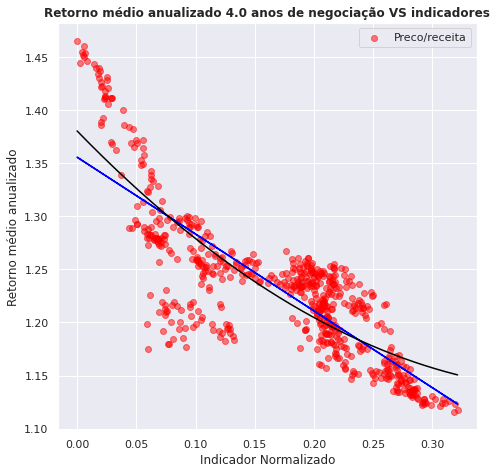

In [ ]:
sns.set()
fig, axs = plt.subplots(figsize=(7.5,7.5), facecolor='w', edgecolor='k')
from sklearn.preprocessing import MinMaxScaler

#Normalizaçãão dos multiplos
carteira['std_preco/pat_liq'] = MinMaxScaler().fit_transform(carteira[['preco/pat_liq']])
carteira['std_preco/ebit'] = MinMaxScaler().fit_transform(carteira[['preco/ebit']])
carteira['std_preco/receita'] =MinMaxScaler().fit_transform(carteira[['preco/receita']])
#carteira['std_preco/lpa'] =MinMaxScaler().fit_transform(carteira[['preco/lpa']])

carteira['retorno_acumulado_anualizado'] = carteira['retorno_acumulado']**(1/anos)

#Definição indicador que benjamin graham usava 22,5*sqrt((p/l)*(p/vp))
carteira['graham'] = (carteira['preco/receita']*carteira['preco/pat_liq']*carteira['preco/ebit'])**1/3
carteira['std_graham'] = MinMaxScaler().fit_transform(carteira[['graham']])

#definições para fazer a regressãão polinimial/linear
my_df = carteira[['std_preco/receita','retorno_acumulado_anualizado']].dropna()
X = pd.DataFrame(my_df.iloc[:,0])
y = pd.DataFrame(my_df.iloc[:,1])

#Regressão linear
X,y_pred = linear(X,y)
axs.plot(X, y_pred, color = 'blue')
  
#Regressao polinomial
X_seq,y_pred2 = poli(X,y,degree = 3)
axs.plot(X_seq,y_pred2,color="black")

#plots
#axs.scatter(y = carteira['retorno_acumulado_anualizado'],x = carteira['std_preco/lpa'], marker='o', color='green', label = 'preco/lucro', alpha =0.5)
#axs.scatter(y = carteira['retorno_acumulado_anualizado'],x = carteira['std_preco/ebit'], marker='o', color='blue', label = 'preco/ebit',alpha =0.5)
#axs.scatter(y = carteira['retorno_acumulado_anualizado'],x = carteira['std_preco/pat_liq'], marker='o', color='green', label = 'Preco/pat_liq', alpha =0.5)
axs.scatter(y = carteira['retorno_acumulado_anualizado'],x = carteira['std_preco/receita'], marker='o', color='red', label = 'Preco/receita', alpha =0.5)
#axs.scatter(y = carteira['retorno_acumulado_anualizado'],x = carteira['std_graham'], marker='o', color='red', label = 'Graham', alpha =0.5)

#axs.axvline(x=carteira['std_preco/receita'].iloc[-1],label = "Nivel atual", color = 'red', alpha =0.5)
#axs.axvline(x=carteira['std_preco/pat_liq'].iloc[-1],label = "Nivel atual", color = 'green', alpha =0.5)
#axs.axvline(x=carteira['std_preco/ebit'].iloc[-1],label = "Nivel atual", color = 'blue', alpha =0.5)
#axs.axvline(x=carteira['std_graham'].iloc[-1],label = "Nivel atual", color = 'red', alpha =0.5)


#legendas  
axs.set_title('Retorno médio anualizado {} anos de negociação VS indicadores'.format(anos), fontsize=12, fontweight ="bold")
axs.set_xlabel("Indicador Normalizado")
axs.set_ylabel("Retorno médio anualizado")
axs.legend()

axs=axs

In [ ]:
carteira.to_csv('carteira.csv')

No handles with labels found to put in legend.


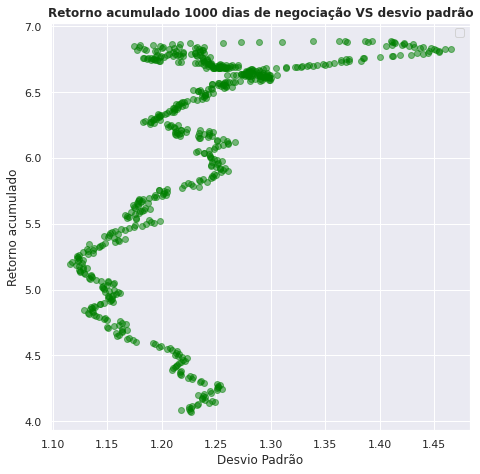

In [ ]:
sns.set()
fig, axs = plt.subplots(figsize=(7.5,7.5), facecolor='w', edgecolor='k')
carteira['desvio_padrao'] = np.sqrt(carteira['variancia'])
#plots
axs.scatter(x = carteira['retorno_acumulado_anualizado'],y = carteira['desvio_padrao'], marker='o', color='green', alpha =0.5)
#axs.scatter(y = carteira['retorno_acumulado'],x = carteira['std_preco/ebit'], marker='o', color='blue', label = 'preco/ebit',alpha =0.5)
#legendas  
axs.set_title('Retorno acumulado {} dias de negociação VS desvio padrão'.format(window), fontsize=12, fontweight ="bold")
#axs.set_xlim(-3,3)
axs.set_xlabel("Desvio Padrão")
axs.set_ylabel("Retorno acumulado")
axs.legend()

axs=axs

In [ ]:
color = 'tab:red'

carteira['date'] = carteira.index

date_to_val = carteira['date'].map(pd.Series(data=np.arange(len(carteira)), index=carteira['date'].values).to_dict())
tickvals = [200*k for k in range(13)]
dlist = list(date_to_val)
index_tickvals = [dlist.index(tv) for tv in tickvals]

ticktext = [carteira['date'][id].strftime("%y-%m-%d") for id in index_tickvals]

customdata = [each_date.strftime("%y-%m-%d") for each_date in carteira['date']]
fig= go.Figure(go.Scatter(y= carteira['variancia'], x=carteira['retorno_acumulado_anualizado'], mode='markers',
                          marker_color=date_to_val, 
                          marker_colorscale='Plasma',
                          marker_showscale=True,
                          marker_size=8,
                          marker_colorbar=dict(tickvals=tickvals, 
                                               ticktext=ticktext),
                         customdata=customdata,
                         hovertemplate="%{customdata}<br>x: %{x}<br>y: %{y}"))

fig.update_layout(width=700, title_text='Retorno x Variancia', title_x=0.5)